In [ ]:
# 必要なパッケージのインストール
import copy
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
transform_dict = {
        'train': transforms.Compose(
            [transforms.Resize((256,256)),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
             ]),
        'test': transforms.Compose(
            [transforms.Resize((256,256)),
             transforms.ToTensor(),
             #transforms.Normalize(mean=[0.485, 0.456, 0.406],
             #                     std=[0.229, 0.224, 0.225]),
             ])}

In [ ]:
# ex.
data_folder_test = "./drive/MyDrive/val"
data_folder_train = "./drive/MyDrive/train"
# transform   = transform_dict["train"]

data_val = torchvision.datasets.ImageFolder(root=data_folder_test, transform=transform_dict["test"])
data_train = torchvision.datasets.ImageFolder(root=data_folder_train, transform=transform_dict["train"])

In [ ]:
#いらない
# ex.
train_ratio = 0.8

train_size = int(train_ratio * len(data))
# int()で整数に。
val_size  = len(data) - train_size      
data_size  = {"train":train_size, "val":val_size}
print(val_size)
print(data_size)
#          =>{"train": 112,       "val": 28}
data_train, data_val = torch.utils.data.random_split(data, [train_size, val_size])
#print(list(data_val))

1128
{'train': 4512, 'val': 1128}


In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(data_val,   batch_size=batch_size, shuffle=False)
dataloaders  = {"train":train_loader, "val":val_loader}

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
"""
# 訓練データをランダムに取得
dataiter = iter(dataloaders["train"])
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % labels[labels[j]] for j in range(8)))
"""

'\n# 訓練データをランダムに取得\ndataiter = iter(dataloaders["train"])\nimages, labels = dataiter.next()\n\n# 画像の表示\nimshow(torchvision.utils.make_grid(images))\n# ラベルの表示\nprint(\' \'.join(\'%5s\' % labels[labels[j]] for j in range(8)))\n'

In [ ]:
# ミニバッチサイズを指定したデータローダーを作成
train_batch = torch.utils.data.DataLoader(dataset=data_train,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=2)  #8
test_batch = torch.utils.data.DataLoader(dataset=data_val,
                                         batch_size=64,
                                         shuffle=False,
                                         num_workers=2)  #8

#print("batch images size: {}".format(image.size))  

"""
# ミニバッチデータセットの確認
for images, labels in train_batch:
    print("batch images size: {}".format(images.size()))  # バッチの画像サイズ
    print("image size: {}".format(images[0].size()))  # 1枚の画像サイズ
    print("batch labels size: {}".format(labels.size()))  # バッチのラベルサイズ
    break
"""

'\n# ミニバッチデータセットの確認\nfor images, labels in train_batch:\n    print("batch images size: {}".format(images.size()))  # バッチの画像サイズ\n    print("image size: {}".format(images[0].size()))  # 1枚の画像サイズ\n    print("batch labels size: {}".format(labels.size()))  # バッチのラベルサイズ\n    break\n'

In [ ]:
###############################################################################
###############################################################################

from torchvision.models import mobilenetv2
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 学習済みのMobilenet_v2を取得
model = mobilenetv2.mobilenet_v2(pretrained=True)
model = model.to(device)
print(model)  # Mobilenet_v2の構造を表示

cpu


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# ニューラルネットワークのパラメータが更新されないようにする

for param in model.parameters():
    param.requires_grad = False
model = model.to(device)
"""
# ニューラルネットワークのパラメータが更新されないようにする
i = 0
for param in model.parameters():
    i = i + 1
    param.requires_grad = False

j = 0
for param in model.parameters():
    if (j == 0):
        param.requires_grad = True
    if (j == 1):
        param.requires_grad = True
    j = j + 1

#param.requires_grad = True
print("---------------------------")
for param in model.parameters():
    print(param.requires_grad)
model = model.to(device)
"""

'\n# ニューラルネットワークのパラメータが更新されないようにする\ni = 0\nfor param in model.parameters():\n    i = i + 1\n    param.requires_grad = False\n\nj = 0\nfor param in model.parameters():\n    if (j == 0):\n        param.requires_grad = True\n    if (j == 1):\n        param.requires_grad = True\n    j = j + 1\n\n#param.requires_grad = True\nprint("---------------------------")\nfor param in model.parameters():\n    print(param.requires_grad)\nmodel = model.to(device)\n'

In [ ]:
#出力層の出力を1000クラス用から10クラス用に変更
print(type(model.classifier[1].in_features))
num_features = model.classifier[1].in_features  # 出力層の入力サイズ 
num_classes = 3  # CIFAR10のクラスの数を指定
model.classifier[1] = nn.Linear(num_features, num_classes).to(device)  # 出力を1000から2へ変更

#print(model)

<class 'int'>


3.4. 損失関数と最適化関数の定義

In [ ]:
# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義
#lr = 0.08
#,lr = lr
#weight_decay = 1
#optimizer = optim.Adam(model.parameters(),weight_decay = weight_decay)
optimizer = optim.SGD(model.parameters(), lr=0.001,weight_decay = 1)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 1
)


3.5. 学習

---------------------------------------------
Epoch: 1/20
実行時間: 296.4740159969999
Train_Loss: 0.9012, Train_Accuracy: 0.5965
Test_Loss: 0.8670, Test_Accuracy: 0.7182
---------------------------------------------
Epoch: 2/20
実行時間: 84.6102035460001
Train_Loss: 0.6934, Train_Accuracy: 0.7979
Test_Loss: 0.7818, Test_Accuracy: 0.7924
---------------------------------------------
Epoch: 3/20
実行時間: 90.49966562700001
Train_Loss: 0.5846, Train_Accuracy: 0.8773
Test_Loss: 0.7341, Test_Accuracy: 0.8214
---------------------------------------------
Epoch: 4/20
実行時間: 97.89896625399979
Train_Loss: 0.5353, Train_Accuracy: 0.8876
Test_Loss: 0.7390, Test_Accuracy: 0.8276
---------------------------------------------
Epoch: 5/20
実行時間: 94.54385701399997
Train_Loss: 0.4851, Train_Accuracy: 0.9080
Test_Loss: 0.6791, Test_Accuracy: 0.8309
---------------------------------------------
Epoch: 6/20
実行時間: 92.58803915799945
Train_Loss: 0.4675, Train_Accuracy: 0.9034
Test_Loss: 0.7621, Test_Accuracy: 0.6451
-----

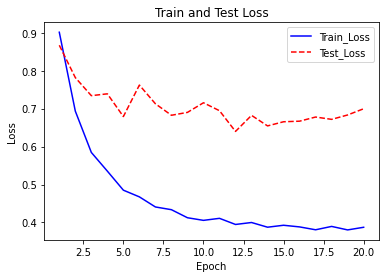

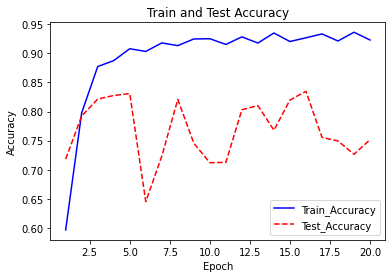

In [ ]:
import time

# 損失と正解率を保存するリストを作成
train_loss_list = []  # 学習損失
train_accuracy_list = []  # 学習データの正答率
test_loss_list = []  # 評価損失
test_accuracy_list = []  # テストデータの正答率

# 学習（エポック）の実行
epoch = 20
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失と正解率の初期化
    train_loss = 0  # 学習損失
    train_accuracy = 0  # 学習データの正答数
    test_loss = 0  # 評価損失
    test_accuracy = 0  # テストデータの正答数
    
    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    model.train()
    # ミニバッチごとにデータをロードし学習
    for images, labels in train_batch:
        # GPUにTensorを転送
        images = images.to(device)
        labels = labels.to(device)

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred_prob = model(images)
        # 損失（誤差）を計算
        loss = criterion(y_pred_prob, labels)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()

        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()

        # 予測したラベルを予測確率y_pred_probから計算
        y_pred_labels = torch.max(y_pred_prob, 1)[1]
        # ミニバッチごとに正解したラベル数をカウント
        train_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)

    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_train_loss = train_loss / len(train_batch)
    epoch_train_accuracy = train_accuracy / len(train_batch)
    # ---------学習パートはここまで--------- #
    
    start = time.perf_counter()

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    model.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for images, labels in test_batch:
            # GPUにTensorを転送
            images = images.to(device)
            labels = labels.to(device)
            # データを入力して予測値を計算（順伝播）
            y_pred_prob = model(images)
            # 損失（誤差）を計算
            loss = criterion(y_pred_prob, labels)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()

            # 予測したラベルを予測確率y_pred_probから計算
            y_pred_labels = torch.max(y_pred_prob, 1)[1]
            # ミニバッチごとに正解したラベル数をカウント
            test_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_test_loss = test_loss / len(test_batch)
    epoch_test_accuracy = test_accuracy / len(test_batch)
    # ---------評価パートはここまで--------- #
    
    end = time.perf_counter()
    print(f"実行時間: {end - start}")

    # エポックごとに損失と正解率を表示
    print("Train_Loss: {:.4f}, Train_Accuracy: {:.4f}".format(
        epoch_train_loss, epoch_train_accuracy))
    print("Test_Loss: {:.4f}, Test_Accuracy: {:.4f}".format(
        epoch_test_loss, epoch_test_accuracy))

    # 損失と正解率をリスト化して保存
    train_loss_list.append(epoch_train_loss)
    train_accuracy_list.append(epoch_train_accuracy)
    test_loss_list.append(epoch_test_loss)
    test_accuracy_list.append(epoch_test_accuracy)

# モデルを保存する。
torch.save(model.state_dict(), "./drive/MyDrive/model15.pth")

# 損失

plt.figure()
plt.title('Train and Test Loss')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Loss')  # 縦軸名
#plt.ylim(0.6,1.8)
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')  # Test_lossのプロット
plt.legend()  # 凡例

# 正解率
plt.figure()
plt.title('Train and Test Accuracy')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Accuracy')  # 縦軸名
#plt.ylim(0.3,0.8)
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue',
         linestyle='-', label='Train_Accuracy')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_accuracy_list, color='red',
         linestyle='--', label='Test_Accuracy')  # Test_lossのプロット
plt.legend()

# 表示
plt.show()

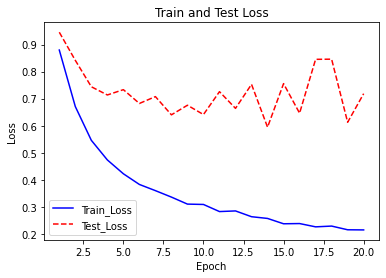

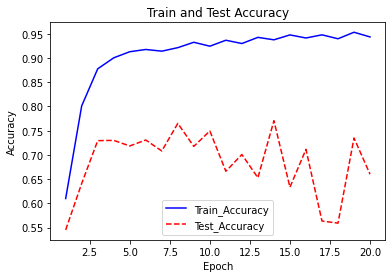

In [ ]:
"""
# モデルを保存する。
torch.save(model.state_dict(), "./drive/MyDrive/model.pth")

# 保存したモデルを読み込む。
model.load_state_dict(torch.load("model.pth"))
"""
# 損失

plt.figure()
plt.title('Train and Test Loss')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Loss')  # 縦軸名
#plt.ylim(0.6,1.8)
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')  # Test_lossのプロット
plt.legend()  # 凡例

# 正解率
plt.figure()
plt.title('Train and Test Accuracy')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Accuracy')  # 縦軸名
#plt.ylim(0.3,0.8)
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue',
         linestyle='-', label='Train_Accuracy')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_accuracy_list, color='red',
         linestyle='--', label='Test_Accuracy')  # Test_lossのプロット
plt.legend()

# 表示
plt.show()

In [ ]:
# 保存したモデルを読み込む。
model.load_state_dict(torch.load("./drive/MyDrive/model2.pth"))

<All keys matched successfully>